## Setup and Imports

In [1]:
import keras
import keras_cv
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
tfds.disable_progress_bar()

2023-07-06 16:10:14.430442: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 16:10:14.483325: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops

## Dataset

In [2]:
# Dataset hyperparameters
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3
NUM_CLASSES = 10

# Algorithm hyperparameter
UNLABELED_BATCH_SIZE = 4096
LABELED_BATCH_SIZE = 128
TEST_BATCH_SIZE = 128
PROJECTION_WIDTH = 128
TEMPERATURE = 0.1

AUTOTUNE = tf.data.AUTOTUNE

In [3]:
def prepare_dataset():
    unlabeled_train_dataset = (
        tfds.load("stl10", data_dir="dataset", split="unlabelled", as_supervised=True)
        .map(lambda image, label: image, num_parallel_calls=AUTOTUNE)
        .shuffle(buffer_size=2 * UNLABELED_BATCH_SIZE)
        .batch(UNLABELED_BATCH_SIZE, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )
    labeled_train_dataset = (
        tfds.load("stl10", data_dir="dataset", split="train", as_supervised=True)
        .shuffle(buffer_size=10 * LABELED_BATCH_SIZE)
        .batch(LABELED_BATCH_SIZE, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )
    test_dataset = (
        tfds.load("stl10", data_dir="dataset", split="test", as_supervised=True)
        .batch(TEST_BATCH_SIZE, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )

    return unlabeled_train_dataset, labeled_train_dataset, test_dataset


# Load STL10 dataset
unlabeled_train_dataset, labeled_train_dataset, test_dataset = prepare_dataset()

2023-07-06 16:10:24.113903: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38169 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


## Augmentation Pipeline

In [4]:
# Stronger augmentations for contrastive
CONTRASTIVE_AUGMENTATION = {
    "crop_area_factor": (0.08, 1.0),
    "aspect_ratio_factor": (3 / 4, 4 / 3),
    "color_jitter_rate": 0.8,
    "brightness_factor": 0.2,
    "contrast_factor" : 0.8,
    "saturation_factor": (0.3, 0.7),
    "hue_factor": 0.2,
}

# Weaker ones for supervised training
CLASSIFICATION_AUGMENTATION = {
    "crop_area_factor": (0.8, 1.0),
    "aspect_ratio_factor": (3 / 4, 4 / 3),
    "color_jitter_rate": 0.05,
    "brightness_factor": 0.1,
    "contrast_factor" : 0.1,
    "saturation_factor": (0.1, 0.1),
    "hue_factor": 0.2,
}

In [5]:
def get_augmenter(
    crop_area_factor,
    aspect_ratio_factor,
    color_jitter_rate,
    brightness_factor,
    contrast_factor,
    saturation_factor,
    hue_factor,
):
    return keras.Sequential([
        keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
        keras_cv.layers.Rescaling(scale=1./255),
        keras_cv.layers.RandomFlip("horizontal"),
        keras_cv.layers.RandomCropAndResize(
            target_size=(IMAGE_SIZE, IMAGE_SIZE),
            crop_area_factor=crop_area_factor,
            aspect_ratio_factor=aspect_ratio_factor,
        ),
        keras_cv.layers.RandomApply(
            keras_cv.layers.RandomColorJitter(
                value_range=(0, 1),
                brightness_factor=brightness_factor,
                contrast_factor=contrast_factor,
                saturation_factor=saturation_factor,
                hue_factor=hue_factor,
            ),
            rate=color_jitter_rate,
        ),
    ])

2023-07-06 16:10:24.800430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [16]
	 [[{{node Placeholder/_4}}]]
2023-07-06 16:10:24.801050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [16]
	 [[{{node Placeholder/_4}}]]


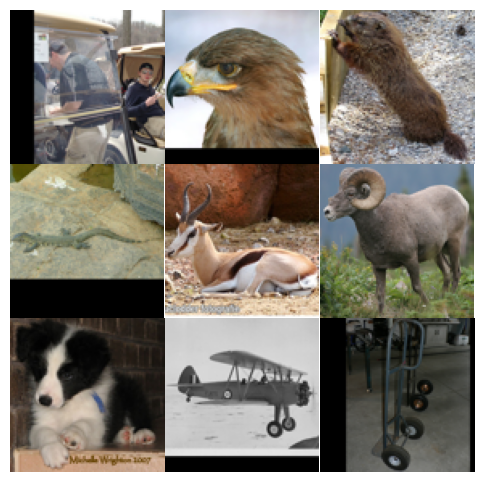

In [6]:
# Original Images
unlabeled_images = next(iter(unlabeled_train_dataset))
keras_cv.visualization.plot_image_gallery(
    images=unlabeled_images,
    value_range=(0, 255),
    rows=3,
    cols=3,
)

2023-07-06 16:10:29.088569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_crop_and_resize/loop_body/CropAndResize/pfor/while/random_crop_and_resize/loop_body/CropAndResize/crop_size' with dtype int32 and shape [2]
	 [[{{node random_crop_and_resize/loop_body/CropAndResize/pfor/while/random_crop_and_resize/loop_body/CropAndResize/crop_size}}]]


2023-07-06 16:10:30.463996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'loop_body/CropAndResize/pfor/while/loop_body/CropAndResize/crop_size' with dtype int32 and shape [2]
	 [[{{node loop_body/CropAndResize/pfor/while/loop_body/CropAndResize/crop_size}}]]


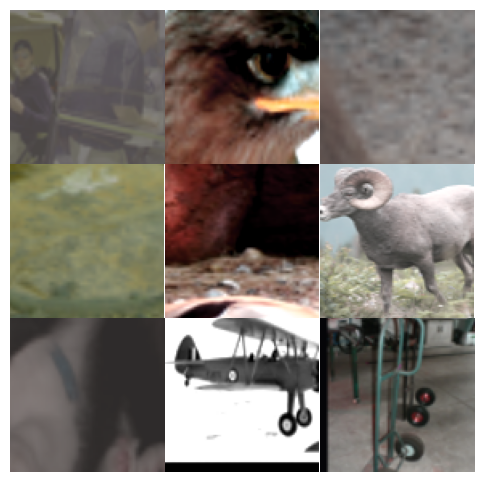

In [7]:
# Contrastive Augmentations
contrastive_augmenter = get_augmenter(**CONTRASTIVE_AUGMENTATION)
augmented_images = contrastive_augmenter(unlabeled_images)
keras_cv.visualization.plot_image_gallery(
    images=augmented_images,
    value_range=(0, 1),
    rows=3,
    cols=3,
)

2023-07-06 16:11:32.337091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_crop_and_resize_1/loop_body/CropAndResize/pfor/while/random_crop_and_resize_1/loop_body/CropAndResize/crop_size' with dtype int32 and shape [2]
	 [[{{node random_crop_and_resize_1/loop_body/CropAndResize/pfor/while/random_crop_and_resize_1/loop_body/CropAndResize/crop_size}}]]


2023-07-06 16:11:33.062069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'loop_body/CropAndResize/pfor/while/loop_body/CropAndResize/crop_size' with dtype int32 and shape [2]
	 [[{{node loop_body/CropAndResize/pfor/while/loop_body/CropAndResize/crop_size}}]]


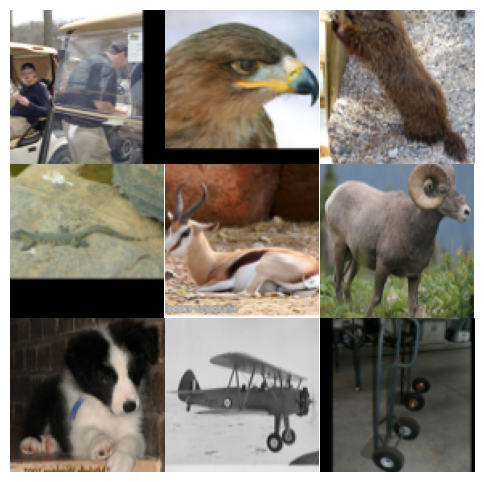

In [8]:
# Classification Augmentations
classification_augmenter = get_augmenter(**CLASSIFICATION_AUGMENTATION)
augmented_images = classification_augmenter(unlabeled_images)
keras_cv.visualization.plot_image_gallery(
    images=augmented_images,
    value_range=(0, 1),
    rows=3,
    cols=3,
)

## Encoder

In [9]:
# Define the encoder architecture
def get_encoder():
    return keras.Sequential([
        keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
        keras_cv.models.ResNet18Backbone(include_rescaling=False),
        keras.layers.GlobalAveragePooling2D(name="avg_pool"),
    ],
        name="encoder",
)

## Supervised Baseline Model

In [10]:
# Baseline supervised training with random initialization
baseline_model = keras.Sequential(
    [
        keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
        get_augmenter(**CLASSIFICATION_AUGMENTATION),
        get_encoder(),
        keras.layers.Dense(NUM_CLASSES),
    ],
    name="baseline_model",
)
baseline_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

baseline_history = baseline_model.fit(
    labeled_train_dataset, epochs=20, validation_data=test_dataset
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_acc"]) * 100
    )
)

2023-07-06 16:11:47.386540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_crop_and_resize_2/loop_body/CropAndResize/pfor/while/random_crop_and_resize_2/loop_body/CropAndResize/crop_size' with dtype int32 and shape [2]
	 [[{{node random_crop_and_resize_2/loop_body/CropAndResize/pfor/while/random_crop_and_resize_2/loop_body/CropAndResize/crop_size}}]]


2023-07-06 16:11:48.981376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'sequential_2/random_crop_and_resize_2/loop_body/CropAndResize/pfor/while/sequential_2/random_crop_and_resize_2/loop_body/CropAndResize/crop_size' with dtype int32 and shape [2]
	 [[{{node sequential_2/random_crop_and_resize_2/loop_body/CropAndResize/pfor/while/sequential_2/random_crop_and_resize_2/loop_body/CropAndResize/crop_size}}]]


Epoch 1/20


2023-07-06 16:11:49.360393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-07-06 16:11:49.360992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


2023-07-06 16:11:50.052048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'baseline_model/sequential_2/random_crop_and_resize_2/loop_body/CropAndResize/pfor/while/baseline_model/sequential_2/random_crop_and_resize_2/loop_body/CropAndResize/crop_size' with dtype int32 and shape [2]
	 [[{{node baseline_model/sequential_2/random_crop_and_resize_2/loop_body/CropAndResize/pfor/while/baseline_model/sequential_2/random_crop_and_resize_2/loop_body/CropAndResize/crop_size}}]]


2023-07-06 16:11:52.062516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'baseline_model/sequential_2/random_crop_and_resize_2/loop_body/CropAndResize/pfor/while/baseline_model/sequential_2/random_crop_and_resize_2/loop_body/CropAndResize/crop_size' with dtype int32 and shape [2]
	 [[{{node baseline_model/sequential_2/random_crop_and_resize_2/loop_body/CropAndResize/pfor/while/baseline_model/sequential_2/random_crop_and_resize_2/loop_body/CropAndResize/crop_size}}]]
2023-07-06 16:11:55.701204: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-07-06 16:11:56.799481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


40/40 [==============================] - ETA: 0s - loss: 1.8709 - acc: 0.3298

2023-07-06 16:12:00.702361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2]
	 [[{{node Placeholder/_1}}]]
2023-07-06 16:12:00.702842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2]
	 [[{{node Placeholder/_0}}]]


2023-07-06 16:12:01.406675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'baseline_model/sequential_2/random_crop_and_resize_2/loop_body/CropAndResize/pfor/while/baseline_model/sequential_2/random_crop_and_resize_2/loop_body/CropAndResize/crop_size' with dtype int32 and shape [2]
	 [[{{node baseline_model/sequential_2/random_crop_and_resize_2/loop_body/CropAndResize/pfor/while/baseline_model/sequential_2/random_crop_and_resize_2/loop_body/CropAndResize/crop_size}}]]


40/40 [==============================] - 17s 239ms/step - loss: 1.8709 - acc: 0.3298 - val_loss: 5.4622 - val_acc: 0.1145
Epoch 2/20
40/40 [==============================] - 7s 167ms/step - loss: 1.4943 - acc: 0.4376 - val_loss: 5.9526 - val_acc: 0.1004
Epoch 3/20
40/40 [==============================] - 7s 171ms/step - loss: 1.3444 - acc: 0.5000 - val_loss: 7.1841 - val_acc: 0.1731
Epoch 4/20
40/40 [==============================] - 7s 171ms/step - loss: 1.2866 - acc: 0.5362 - val_loss: 4.6982 - val_acc: 0.1121
Epoch 5/20
40/40 [==============================] - 7s 166ms/step - loss: 1.1861 - acc: 0.5726 - val_loss: 3.1048 - val_acc: 0.2366
Epoch 6/20
40/40 [==============================] - 7s 168ms/step - loss: 1.0955 - acc: 0.6068 - val_loss: 5.7225 - val_acc: 0.1239
Epoch 7/20
40/40 [==============================] - 7s 167ms/step - loss: 1.0507 - acc: 0.6162 - val_loss: 3.7982 - val_acc: 0.2244
Epoch 8/20
40/40 [==============================] - 7s 175ms/step - loss: 0.9976 - acc

## Self-supervised model for contrastive pretraining

In [11]:
class SimCLRTrainer(keras_cv.training.ContrastiveTrainer):
    def __init__(self, encoder, augmenter, projector, probe=None, **kwargs):
        super().__init__(
            encoder=encoder,
            augmenter=augmenter,
            projector=projector,
            probe=probe,
            **kwargs,
        )

In [12]:
simclr_model = SimCLRTrainer(
    encoder=get_encoder(),
    augmenter=get_augmenter(**CONTRASTIVE_AUGMENTATION),
    projector=keras.Sequential(
        [
            keras.layers.Dense(PROJECTION_WIDTH, activation="relu"),
            keras.layers.Dense(PROJECTION_WIDTH),
            keras.layers.BatchNormalization(),
        ],
        name="projector",
    ),
)

simclr_model.compile(
    encoder_optimizer=keras.optimizers.Adam(),
    encoder_loss=keras_cv.losses.SimCLRLoss(
        temperature=TEMPERATURE,
    ),
)

2023-07-06 16:14:20.514875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_crop_and_resize_3/loop_body/CropAndResize/pfor/while/random_crop_and_resize_3/loop_body/CropAndResize/crop_size' with dtype int32 and shape [2]
	 [[{{node random_crop_and_resize_3/loop_body/CropAndResize/pfor/while/random_crop_and_resize_3/loop_body/CropAndResize/crop_size}}]]


In [13]:
simclr_history = simclr_model.fit(
    unlabeled_train_dataset,
    epochs=20,
)

2023-07-06 16:14:21.709052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'sequential_3/random_crop_and_resize_3/loop_body/CropAndResize/pfor/while/sequential_3/random_crop_and_resize_3/loop_body/CropAndResize/crop_size' with dtype int32 and shape [2]
	 [[{{node sequential_3/random_crop_and_resize_3/loop_body/CropAndResize/pfor/while/sequential_3/random_crop_and_resize_3/loop_body/CropAndResize/crop_size}}]]


2023-07-06 16:14:22.517090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'sequential_3/random_crop_and_resize_3/loop_body_1/CropAndResize/pfor/while/sequential_3/random_crop_and_resize_3/loop_body_1/CropAndResize/crop_size' with dtype int32 and shape [2]
	 [[{{node sequential_3/random_crop_and_resize_3/loop_body_1/CropAndResize/pfor/while/sequential_3/random_crop_and_resize_3/loop_body_1/CropAndResize/crop_size}}]]
2023-07-06 16:14:22.991495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [16]
	 [[{{node Placeholder/_3}}]]
2023-07-06 16:14:22.992073: I tensorflow/core/commo

Epoch 1/20
25/25 [==============================] - 93s 2s/step - loss: 16.5717
Epoch 2/20
25/25 [==============================] - 83s 2s/step - loss: 13.4816
Epoch 3/20
25/25 [==============================] - 82s 2s/step - loss: 12.0345
Epoch 4/20
25/25 [==============================] - 83s 3s/step - loss: 11.0738
Epoch 5/20
25/25 [==============================] - 82s 2s/step - loss: 10.2709
Epoch 6/20
25/25 [==============================] - 83s 2s/step - loss: 9.6902
Epoch 7/20
25/25 [==============================] - 80s 2s/step - loss: 9.2672
Epoch 8/20
25/25 [==============================] - 83s 3s/step - loss: 8.9160
Epoch 9/20
25/25 [==============================] - 82s 3s/step - loss: 8.4965
Epoch 10/20
25/25 [==============================] - 83s 3s/step - loss: 8.3147
Epoch 11/20
25/25 [==============================] - 82s 2s/step - loss: 8.0335
Epoch 12/20
25/25 [==============================] - 82s 2s/step - loss: 7.8109
Epoch 13/20
25/25 [=========================

## Fine tuning

In [14]:
# Supervised finetuning of the pretrained encoder
finetune_model = keras.Sequential(
    [
        keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
        get_augmenter(**CLASSIFICATION_AUGMENTATION),
        simclr_model.encoder,
        keras.layers.Dense(NUM_CLASSES),
    ],
    name="finetuning_model",
)
finetune_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

2023-07-06 16:42:20.932331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_crop_and_resize_4/loop_body/CropAndResize/pfor/while/random_crop_and_resize_4/loop_body/CropAndResize/crop_size' with dtype int32 and shape [2]
	 [[{{node random_crop_and_resize_4/loop_body/CropAndResize/pfor/while/random_crop_and_resize_4/loop_body/CropAndResize/crop_size}}]]


2023-07-06 16:42:21.727176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'sequential_4/random_crop_and_resize_4/loop_body/CropAndResize/pfor/while/sequential_4/random_crop_and_resize_4/loop_body/CropAndResize/crop_size' with dtype int32 and shape [2]
	 [[{{node sequential_4/random_crop_and_resize_4/loop_body/CropAndResize/pfor/while/sequential_4/random_crop_and_resize_4/loop_body/CropAndResize/crop_size}}]]


In [15]:
finetune_history = finetune_model.fit(
    labeled_train_dataset, epochs=20, validation_data=test_dataset
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetune_history.history["val_acc"]) * 100
    )
)

Epoch 1/20


2023-07-06 16:42:22.714512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'finetuning_model/sequential_4/random_crop_and_resize_4/loop_body/CropAndResize/pfor/while/finetuning_model/sequential_4/random_crop_and_resize_4/loop_body/CropAndResize/crop_size' with dtype int32 and shape [2]
	 [[{{node finetuning_model/sequential_4/random_crop_and_resize_4/loop_body/CropAndResize/pfor/while/finetuning_model/sequential_4/random_crop_and_resize_4/loop_body/CropAndResize/crop_size}}]]


2023-07-06 16:42:24.676069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'finetuning_model/sequential_4/random_crop_and_resize_4/loop_body/CropAndResize/pfor/while/finetuning_model/sequential_4/random_crop_and_resize_4/loop_body/CropAndResize/crop_size' with dtype int32 and shape [2]
	 [[{{node finetuning_model/sequential_4/random_crop_and_resize_4/loop_body/CropAndResize/pfor/while/finetuning_model/sequential_4/random_crop_and_resize_4/loop_body/CropAndResize/crop_size}}]]


39/40 [============================>.] - ETA: 0s - loss: 1.6190 - acc: 0.4305WARNING:tensorflow:Using a while_loop for converting CropAndResize cause there is no registered converter for this op.


2023-07-06 16:42:30.191190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'finetuning_model/sequential_4/random_crop_and_resize_4/loop_body/CropAndResize/pfor/while/finetuning_model/sequential_4/random_crop_and_resize_4/loop_body/CropAndResize/crop_size' with dtype int32 and shape [2]
	 [[{{node finetuning_model/sequential_4/random_crop_and_resize_4/loop_body/CropAndResize/pfor/while/finetuning_model/sequential_4/random_crop_and_resize_4/loop_body/CropAndResize/crop_size}}]]


40/40 [==============================] - 13s 211ms/step - loss: 1.6194 - acc: 0.4308 - val_loss: 14.6123 - val_acc: 0.1145
Epoch 2/20
40/40 [==============================] - 7s 170ms/step - loss: 1.2854 - acc: 0.5280 - val_loss: 4.7240 - val_acc: 0.2674
Epoch 3/20
40/40 [==============================] - 7s 168ms/step - loss: 1.1613 - acc: 0.5790 - val_loss: 2.8433 - val_acc: 0.2887
Epoch 4/20
40/40 [==============================] - 7s 165ms/step - loss: 1.0271 - acc: 0.6228 - val_loss: 2.3110 - val_acc: 0.4033
Epoch 5/20
40/40 [==============================] - 7s 169ms/step - loss: 0.9432 - acc: 0.6614 - val_loss: 2.5950 - val_acc: 0.3820
Epoch 6/20
40/40 [==============================] - 7s 169ms/step - loss: 0.9295 - acc: 0.6614 - val_loss: 7.8815 - val_acc: 0.1771
Epoch 7/20
40/40 [==============================] - 7s 172ms/step - loss: 0.8575 - acc: 0.6840 - val_loss: 2.8994 - val_acc: 0.3746
Epoch 8/20
40/40 [==============================] - 7s 169ms/step - loss: 0.7750 - ac

# Visualization

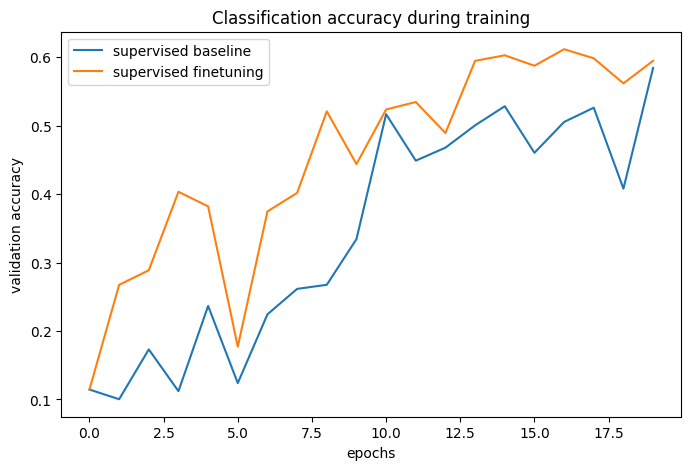

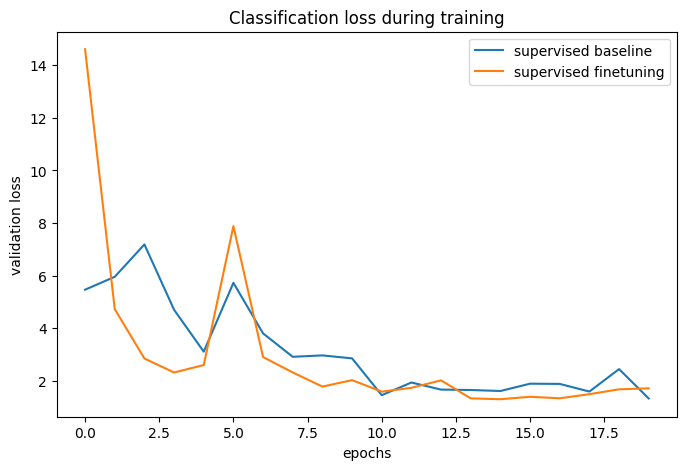

In [17]:
# The classification accuracies of the baseline and finetuning process:
def plot_training_curves(baseline_history, finetune_history):
    for metric_key, metric_name in zip(["acc", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            baseline_history.history[f"val_{metric_key}"],
            label="supervised baseline"
        )
        plt.plot(
            finetune_history.history[f"val_{metric_key}"],
            label="supervised finetuning",
        )
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_training_curves(baseline_history, finetune_history)